In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Project Description: 
This is a simple model to simulate the spread of fires in a forest. The inspiration for the model comes from many texts and is alluded to often in the complexity literature. I am recreating the model here to demonstrate the model in python and see how initial conditions (forest density, lightning strikes) determine the dynamics and outcome of the system. 

The model assumes a grid like structure where values for each square in the grid represent the state of the square. A square can either be a tree, a tree on fire, charred, or empty. The density of the forest is the count of trees/total area. Fire is spread through a von Neumann neighborhood where if any of the four neighbors are on fire, and the current spot is a tree, it will erupt in flames. Every time step this continues. 
There are some parameters that have to be set by the user, namely the initial forest density and if the model allows regrowth of trees in spots that have been burnt out. If regrowth is allowed the probability of regrowth is based on the starting density. 

In the analysis, I have sampled the model to calculate average trees burned while varying both the initial forest density and the amount of lightening strikes.  Then I vary them at the same time to see the join impact. 


 

In [357]:
import random
import warnings
from pandas import *
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

The cells that represent the forest in the model are implemented using object oriented programing. Below each cell is asigned a state, a growth potential, and a location in the forest. 

Methods are simply updating--> where the cell looks to its neighbors and changes states, and lightning strikes, which happen at the begining of the model. 



In [358]:
class Agent():
    states= {"Open":0, "Tree":1, "Fire":2, "Charred":3}
    
    def __init__(self,area,density):
        if random.uniform(0,1) < density:
            self.state=1
        else:
            self.state=0
        self.counter=0
        self.growth=random.uniform(0,1)
        self.x=random.randint(0,len(area)-1)
        self.y=random.randint(0,len(area[0])-1)
        while(area[self.x][self.y]!=None):
            self.x=random.randint(0,len(area)-1)
            self.y=random.randint(0,len(area[0])-1)
        area[self.x][self.y]=self


    def Update(self,state,counter,density):
        if self.state==3:
            self.state=0
        else:
            if self.state==0:
                self.state=.5
            else:
                if self.state==1:#if it is a tree
                    if self.x!=(len(area)-1): #find out if it on the end
                        if area[self.x+1][self.y].state==2:# or area[self.x+1][self.y].state==3: # if it is not on the end, neighbor is on fire , catch fire
                            self.state=2
                            self.counter=self.counter+1
                    if self.x!=0:
                        if area[self.x-1][self.y].state==2:# or area[self.x-1][self.y].state==3:
                            self.state=2
                            self.counter=self.counter+1
                    if self.y!=(len(area))-1:
                        if area[self.y+1][self.x].state==2:# or area[self.y+1][self.x].state==3:
                            self.state=2
                            self.counter=self.counter+1
                    if self.y!=0:
                        if area[self.y-1][self.x].state==2:# or area[self.y-1][self.x].state==3:
                            self.state=2
                            self.counter=self.counter+1
                else: 
                    if self.state==2:
                        self.state=3
                    else:
                        if self.state==.5 and Regrow==True:
                            if random.uniform(0,1) < (density):
                                self.state=1
                            else: 
                                self.state=0
            
    def lightning(self,state): # if lightning hits a tree, it catches on fire
        if self.state==1:
        self.state=2
        
    def __str__(self):
        return "{0} is my state and I am at {1},{2}".format(self.state, self.x, self.y)


This next funciton is a function that resets and implements the model. 

In [367]:
def runModel(iterations,strikes,xDim,density,images,regrow,graphEvery):
    LIST=list()
    states=list()
    global area
    area=list()
    yDim=xDim
    view=list()
    global Regrow #probably a better way to do this, but it just allows this to be reset from outside of the function
    if regrow==True:
        Regrow=True
    else:
        Regrow=False

    for x in range(xDim): # create the forest area
        area.append(list())
        view.append(list())
        for y in range(yDim):
            area[x].append(None)
            view[x].append(0)
        
    for i in range(xDim):# populate the forest with cells 
        LIST.append(list())
        for j in range(yDim):
            LIST[i].append(Agent(area,density)) # add a cell to every slot in the forest
        
    for i in range(xDim): # document the state of each cell 
        for j in range(yDim):
            states.append(LIST[i][j])
    ####End of setup 
    
    ## these lists capture data for plotting 
    trees=list()
    fires=list()
    empty=list()
    charred=list()
    # each iteration of the model has its own data space
    for iteration in range(iterations):
        trees.append([])
        fires.append([])
        empty.append([])
        charred.append([])
    # documenting the state of each cell for an image
    for i in range(xDim*yDim):
        view[states[i].x][states[i].y]=states[i].state
        
#The below commented plot shows the spread of the fire on an image. If doing multiple runs of the mode, it is best to leave commented
        
    #imshow(view, interpolation="nearest", vmin=0, vmax=3)
    #cbar = plt.colorbar()
    #cbar.ax.set_yticklabels(['Open','','', 'Tree','','','Fire','','' ,'Charred'])
    #cbar.set_label('state of cell', rotation=270)
    #figure()
    
    
# applying lightning strikes to a location. Location was assigned randomly so 'i' works 
# the lightning strikes happen at the start of the simulation
    for s in range(strikes):
        states[i].lightning(states[i].state)
        
# after the lightning strike, the fire begins to spread
    for run in range(iterations):
        tTree=list() # create temporary data holders
        tFire=list()
        tEmpty=list()
        tCharred=list()
        for i in range(xDim*yDim): # Spread the fire based on nieghbor's state
            states[i].Update(states[i].state,states[i].counter,density)
        for i in range(xDim*yDim):
            view[states[i].x][states[i].y]=states[i].state
            if states[i].state==1:
                tTree.append(1)
            else:
                if states[i].state==2: #or states[i].state==3:
                    tFire.append(1)
                else:
                    if states[i].state==3:
                        tCharred.append(1)
                    else:
                        if states[i].state==0 or states[i].state==.5:
                            tEmpty.append(1)
    #this is a relic function to stop the model when the fire went out, uncessary now.    
        #if len(tFire)<2:
            #print "Fire extinquished at {0}".format(run)
            #raise Exception('fire went out')
            #return
            #return 
# calculate the percent density of the forest after each update
        trees[run]=(float(sum(tTree))/(xDim*yDim)*100)
        fires[run]=(float(sum(tFire))/(xDim*yDim)*100)
        charred[run]=(float(sum(tCharred))/(xDim*yDim)*100)
        empty[run]=(float(sum(tEmpty))/(xDim*yDim)*100)
            #if sum(fires[run])<1:
            #print "Fire extinguished in {0} runs".format(run)
            #exit()
# if the user wants to see the simulation, true will show (slow)
        if images==True:
            imshow(view, interpolation="nearest", vmin=0, vmax=3)
            cbar = plt.colorbar()
            cbar.ax.set_yticklabels(['Open','','', 'Tree','','','Fire','','' ,'Charred'])
            cbar.set_label('state of cell', rotation=270)
            figure()
    #figure()
    # plot of results, if true, you will see a plot after every model run. 
    if graphEvery==True:
        plt.plot(fires, 'r', trees, 'g', charred, 'b', empty ,'y')
        xlabel("Time")
        ylabel("Percent of Forest")
        red_patch = mpatches.Patch(color='red', label='Burning')
        green_patch = mpatches.Patch(color='green', label='Trees')
        yellow_patch = mpatches.Patch(color='yellow', label='Open')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.legend(handles=[red_patch, yellow_patch, green_patch])
        plt.title('Graph 1: Changes in Forest')
        figure()
    global FIRES
    FIRES=fires
    
    
    


# Results
Below you will see the results of a model run with a 55% starting density and 8 lightning strikes. With regrowth on, 55% becomes an interesting density to run the model. As you see below, the model can have a burning fire that quickly overtakes the forest and then the forest grows back. Or, as the next run shows, the model can get into an oscillation pattern where fires and forests oscilate around 30-35% percent.  
 

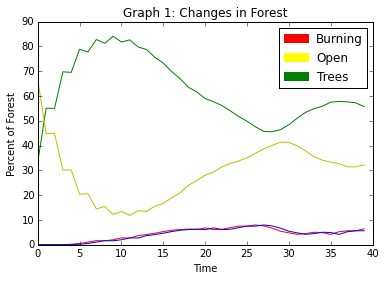

In [389]:
runModel(40,8,100,0.33,False,True,True)#runs,strikes,dimension,density# add images T/F add Growth T/F, Graphs/t/f


CAUTION: Don't run the next cell. It takes over an hour, but was an important part of the analysis. 
The following cell runs the model 50 times with 50 iterations each for the 16 different varying conditions simultaneaously. It then plots the averages for each 50 iterations for the % of forest burned. 
The follow graph shows the impact of the initial conditions on a heat map. 

In [414]:
## DO NOT RUN UNLESS YOU HATE 1+ hours to wait! ! ! ! 
### MORE ANALYSIS BELOW 
# vary density and Strikes together for heat map 
#for density 25-85%
# for strikes 
D=[.25,.35,.45,.55,.65,.75,.85]
S=[1,2,3,4,5,6,7,8,9]
data=list()

for density in range(len(D)):
    data.append([])
    countfires=list()
    averages=list()
    for strike in range(len(S)):
        data[density].append(None)
        for i in range(50):
            runModel(50,S[strike],100,D[density],False,False,False)
            countfires.append([])
            countfires[i]=(FIRES)
            averages.append(sum(countfires[i]))
    
        data[density][strike]=numpy.mean(averages)
        print density,strike # to make sure the loop worked. Would remove, but I don't want to run it again.
print data  

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
[[0.037400000000000003, 0.034500000000000003, 0.035333333333333335, 0.033050000000000003, 0.033080000000000005, 0.034099999999999998, 0.034028571428571429, 0.034075000000000001, 0.034444444444444451], [0.14499999999999999, 0.11580000000000001, 0.12606666666666666, 0.12040000000000001, 0.11976000000000001, 0.12756666666666666, 0.12308571428571428, 0.11927500000000002, 0.11573333333333333], [1.1481999999999999, 1.079, 1.1163999999999998, 1.0757999999999999, 1.0824800000000001, 1.0618333333333334, 1.0625142857142857, 1.0446249999999999, 1.0352444444444444], [28.904200000000007, 25.785599999999999, 25.991333333333333, 26.439649999999997, 26.571639999999999, 26.518366666666669, 26.432199999999995, 26.751774999999999, 26.624444444444446], [54.9

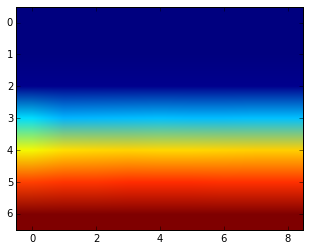

In [416]:
plt.imshow(data)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 0
6 1
6 2
6 3
6 4
6 5
6 6


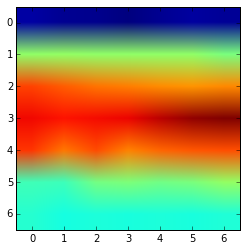

In [417]:
# vary density and Strikes together for heat map 
#for density 20-80%
# with growth on 
D=[.25,.35,.45,.55,.65,.75,.85]
S=[1,2,3,4,5,6,7]
data=list()

for density in range(len(D)):
    data.append([])
    countfires=list()
    averages=list()
    for strike in range(len(S)):
        data[density].append(None)
        for i in range(50):
            runModel(50,S[strike],100,D[density],False,True,False)
            countfires.append([])
            countfires[i]=(FIRES)
            averages.append(sum(countfires[i]))
    
        data[density][strike]=numpy.mean(averages)
        print density,strike
imshow(data)

The following heat maps demonstrates what happens when running the model while varying the starting density of the forest and the amount of strikes. 

The Y axis is increasing the density of the forest. 
The X axis is increasing the amount of strikes 

The first graph demonstrates what happens with when the forest cannot regrow. The graph shows that increasing the amount of strikes is not too important to the amount of forest that is burned, but increasing the density of the forest is vital. 

The second growth is allowed. 
This graph is more interesting in that, mid- level densities have more fires, which if you run the model with the images on you see that this allows for a slower fire, and smaller fires that burn while trees are growing. Highly dense forests burn straight through with the forest growing behind the fire’s leading edge. 


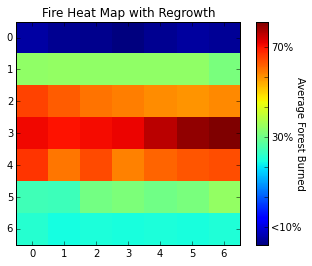

In [436]:
## fire heat map with regrowth 
## NEED AXIS TITLES AND scale? ? 
imshow(data, interpolation="nearest")
plt.title("Fire Heat Map with Regrowth")

cbar = plt.colorbar()
cbar.ax.set_yticklabels(['<10%','','', '30%','','','70%','','' ,''])
cbar.set_label('Average Forest Burned', rotation=270)
figure()

# Conclusions: 

Varying the intital amount of lightning strikes does not determine the outcome of the forest fire, however the density of the forest at starting is infact very important as one would assume. 

For future work the model could use a more stochastic time aspect of lightening strikes, allowing them to happen at any point in the model simulaiton. I would also like build functionality to have the growth rate for each cell to depend on some intial endowment and how long it has been since the last time it burned. This could possibily yeild interesting results on the resilence of a forest system that depends on fire for rebirth. 


